Loading BokehJS ...

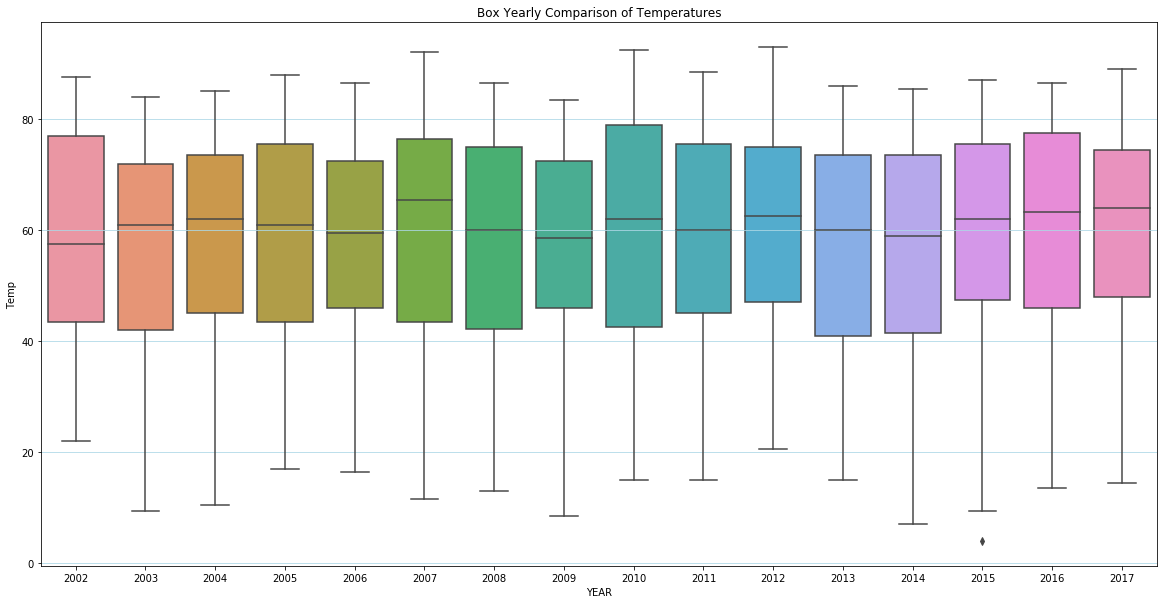

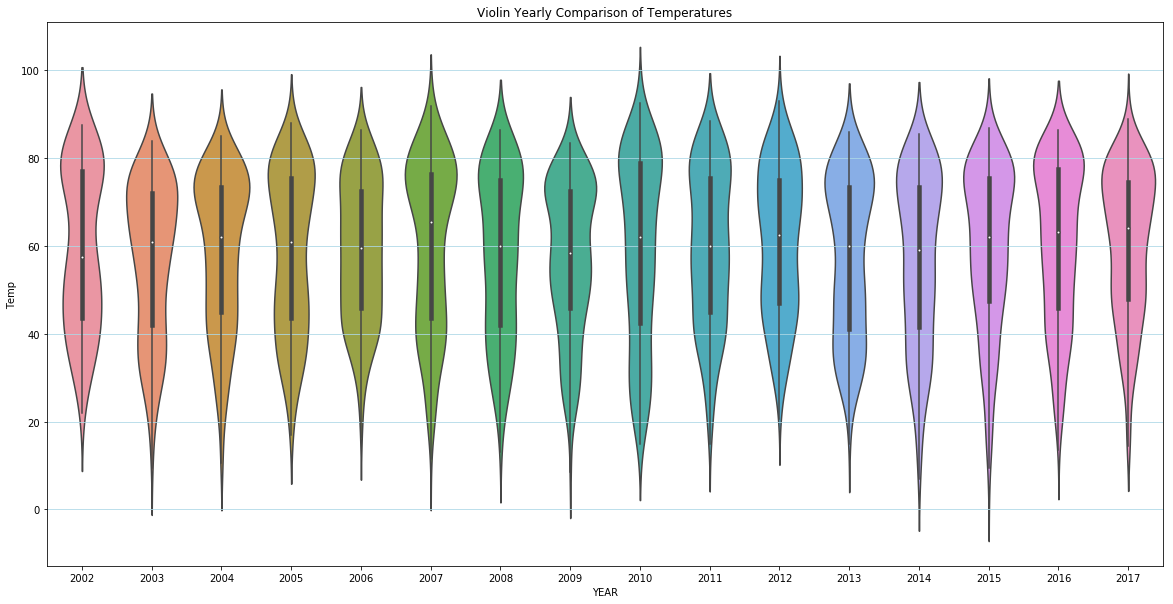

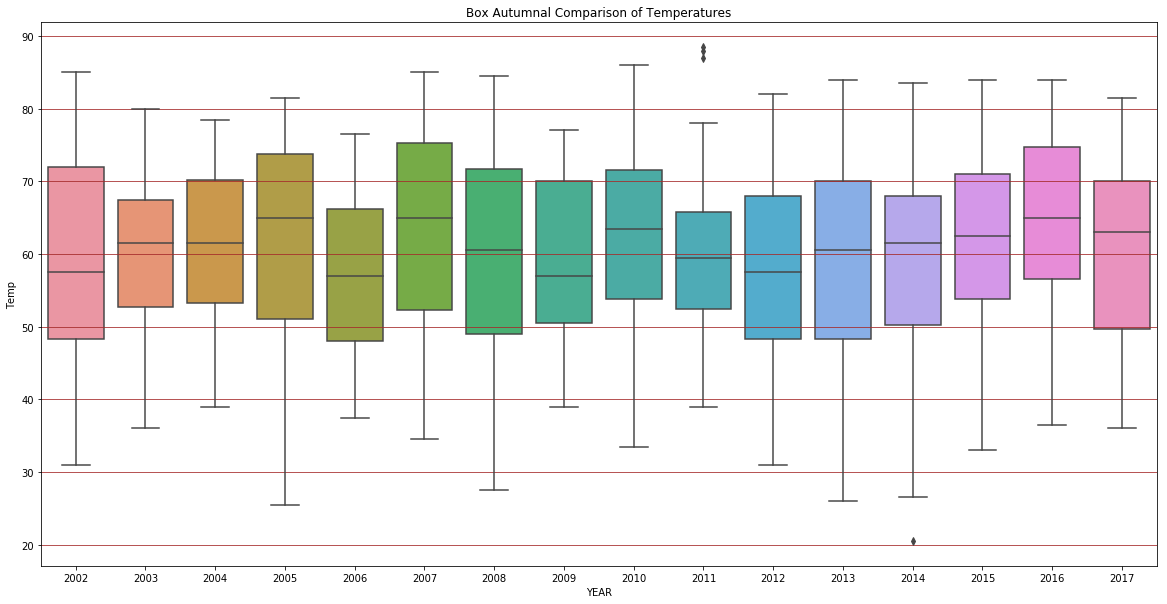

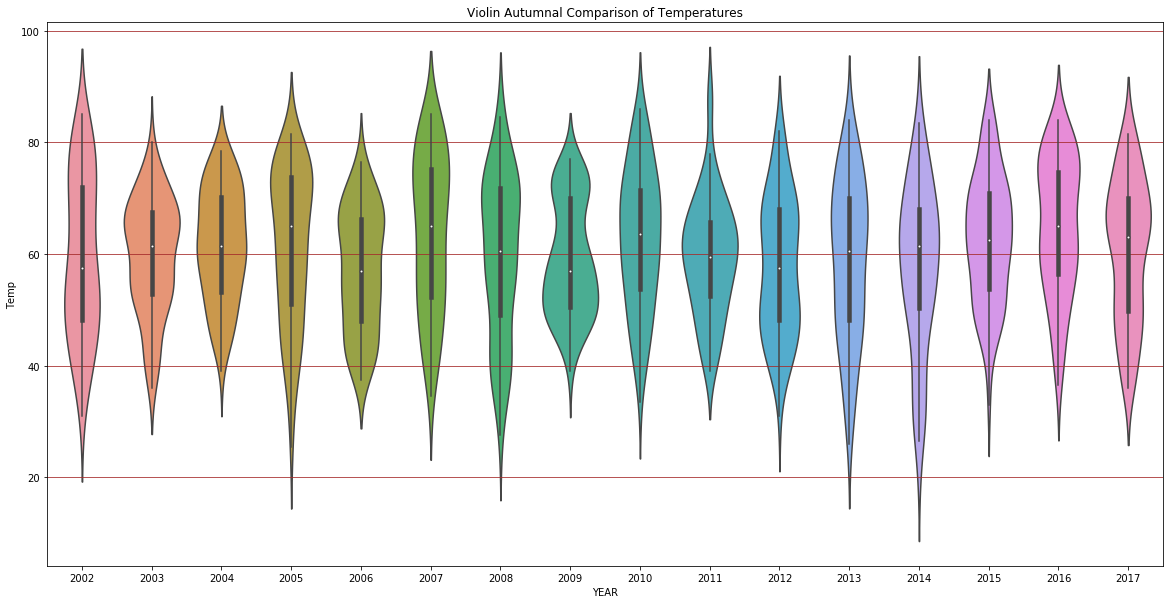

In [2]:
from bokeh.layouts import gridplot, column
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool, Div
from bokeh.plotting import figure
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
#import numpy as np


    
def hottest_day_counter(weather):
    temp_uphi = weather.loc[weather.groupby(['MONTH', 'DAY'])['high'].idxmax()]
    temp_dlo = weather.loc[weather.groupby(['MONTH', 'DAY'])['low'].idxmax()]

    temp_uhi_data = temp_uphi.groupby('YEAR').size()
    temp_dlo_data = temp_dlo.groupby('YEAR').size() * -1

    p = figure(width=1000, plot_height=500)
    p.xgrid.grid_line_color=None
    p.ygrid.grid_line_color='red'
    p.ygrid.grid_line_alpha=0.5
    p.xaxis.axis_label = 'Years'
    p.yaxis.axis_label = "Num of Lowest Lows \t|| \tNum of Highest Highs"
    p.line(temp_uhi_data.index, temp_uhi_data.values, line_width=2, color='red', legend="Max Highs")
    p.line(temp_dlo_data.index, temp_dlo_data.values, line_width=2, color='blue', legend="Min Lows")

    return p

# The function to create the AVG_MONTH_TEMP by YEAR
def temp_plots(month, data, mn, mx):
    # Names for Titles
    month_names = {
                  1:"January",
                  2: "February",
                  3: "March",
                  4: "April",
                  5: "May",
                  6: "June",
                  7: "July",
                  8: "August",
                  9: "September",
                  10: "October",
                  11: "November",
                  12: "December"
                  }

    p = figure(width=500, plot_height=250, y_range=(mn, mx), title = month_names[month])
    p.xgrid.grid_line_color=None
    p.ygrid.grid_line_color='red'
    p.ygrid.grid_line_alpha=0.5
    p.xaxis.axis_label = 'Years'
    p.yaxis.axis_label = "Temperature"
    
    p.line(data.YEAR, data.high, line_width=2, color='red', legend="yearly high temp")
    p.line(data.YEAR, data.low, line_width=2, color='blue', legend="yearly low temp")
        
    p.legend.location = "top_left"
    p.legend.orientation = "horizontal"
    p.legend.padding = 1

    return p


# Grouping 
def data_grid(lst, col=2):
    output = []
    for i in range(0, len(lst), col):
        if (i + (col - 1)) >= len(lst):
            output.append(lst[i:])
        else:
            output.append(lst[i:(i+(col))])
    return output

############ Configure the data
def main():
    output_notebook()
    
    #Collect the data from SQL
    conn = sqlite3.connect('weather.db')
    weather = pd.read_sql('select DATE, (TMAX+TMIN)/2 Temp, TMAX high, TMIN low, YEAR, MONTH, DAY from weather where station = "USW00093821" and YEAR < 2018', conn)
    avg_month_temp = pd.read_sql("Select Month, Year, AVG(TMAX) high, AVG(TMIN) low, AVG((TMAX+TMIN)/2) temp from weather group by 1, 2", conn)
    month_group = avg_month_temp.groupby('MONTH')
    # Retrieve temp range from sql results
    max_temp, min_temp = (weather.high.max() + 10), weather.low.min()
    
    #Collect the plots for the Monthly Comparison grid
    years = []
    for name, group in month_group:
        years.append(temp_plots(name, group, min_temp, max_temp))
    show(column(Div(text="<h2>Quantity of Hottest Days</h2>")))
    show(hottest_day_counter(weather))
    show(column(Div(text="<h2>Months Temp by Year</h2>")))
    show(gridplot(data_grid(years)))
    show(column(Div(text="<h2>Comparison of Overviews</h2>")))
    #Box/Violin plots per Year
    plt.subplots(figsize=(20,10))
    sns.boxplot(x=weather['YEAR'], y=weather['Temp']).set_title("Box Yearly Comparison of Temperatures")
    plt.grid(axis='y', color='lightblue')
    plt.subplots(figsize=(20,10))
    sns.violinplot(x=weather['YEAR'], y=weather['Temp']).set_title("Violin Yearly Comparison of Temperatures")
    plt.grid(axis='y', color='lightblue')
    #Box/Violin plots of Autumn
    autumn = weather[weather['MONTH'].isin([9, 10, 11])]
    plt.subplots(figsize=(20,10))
    sns.boxplot(x=autumn['YEAR'], y=autumn['Temp']).set_title("Box Autumnal Comparison of Temperatures")
    plt.grid(axis='y', color='brown')
    plt.subplots(figsize=(20,10))
    sns.violinplot(x=autumn['YEAR'], y=autumn['Temp']).set_title("Violin Autumnal Comparison of Temperatures")
    plt.grid(axis='y', color='brown')

main()